In [170]:
import pandas as pd
import scipy.optimize as opt;
import re
from io import BytesIO
import numpy as np
import cairo
import IPython.display

epoch = 1

Df = pd.read_csv("../../membershipchainservice/Data/gentree-node_0-epoch"+str(epoch))
Df

,Name,Level,X,Y,cluster,bunch
0,node_0,1,40.309273,254.230121,map[],map[node_2:true]
1,node_1,0,246.532589,87.920694,map[],map[node_2:true]
2,node_2,2,148.630526,134.847319,map[node_0:true node_1:true node_3:true],map[]
3,node_3,0,195.477892,236.617005,map[],map[node_2:true]


In [171]:
def transform_Df(Df):
    regex = r"(node_[0-9]+)"
    explode_list_lambda = lambda map_str : [m.group() for m in re.finditer(regex, map_str, re.MULTILINE)]
    Df["cluster_list"] = Df["cluster"].apply(explode_list_lambda)
    Df["bunch_list"] = Df["bunch"].apply(explode_list_lambda)

transform_Df(Df)
Df

,Name,Level,X,Y,cluster,bunch,cluster_list,bunch_list
0,node_0,1,40.309273,254.230121,map[],map[node_2:true],[],[node_2]
1,node_1,0,246.532589,87.920694,map[],map[node_2:true],[],[node_2]
2,node_2,2,148.630526,134.847319,map[node_0:true node_1:true node_3:true],map[],"[node_0, node_1, node_3]",[]
3,node_3,0,195.477892,236.617005,map[],map[node_2:true],[],[node_2]


In [172]:
def cover_cluster(radius, name, Df):
    node = Df[Df["Name"]==name]
    cl = list(Df[Df["Name"]==name].cluster_list)[0]
    if len(cl) == 0:
        return True
    
    distance_lambda = lambda row : np.sqrt((row.X-node.X)**2 + (row.Y-node.Y)**2)
    distances = Df[Df["Name"].isin(cl)].apply(distance_lambda, axis=1)
    if radius < distances.max().values[0]:
        return False
    
    return True
    
def compute_radius(name, Df, base):
    radius = base
    while not cover_cluster(radius, name, Df):
        radius *= 2
    return radius

In [173]:
palette = [
    [64/255, 64/255, 122/255,1.0],
    [255/255, 121/255, 63/255,1.0],
    [255/255, 177/255, 66/255,1.0],
    [52/255, 172/255, 224/255,1.0],
    
]

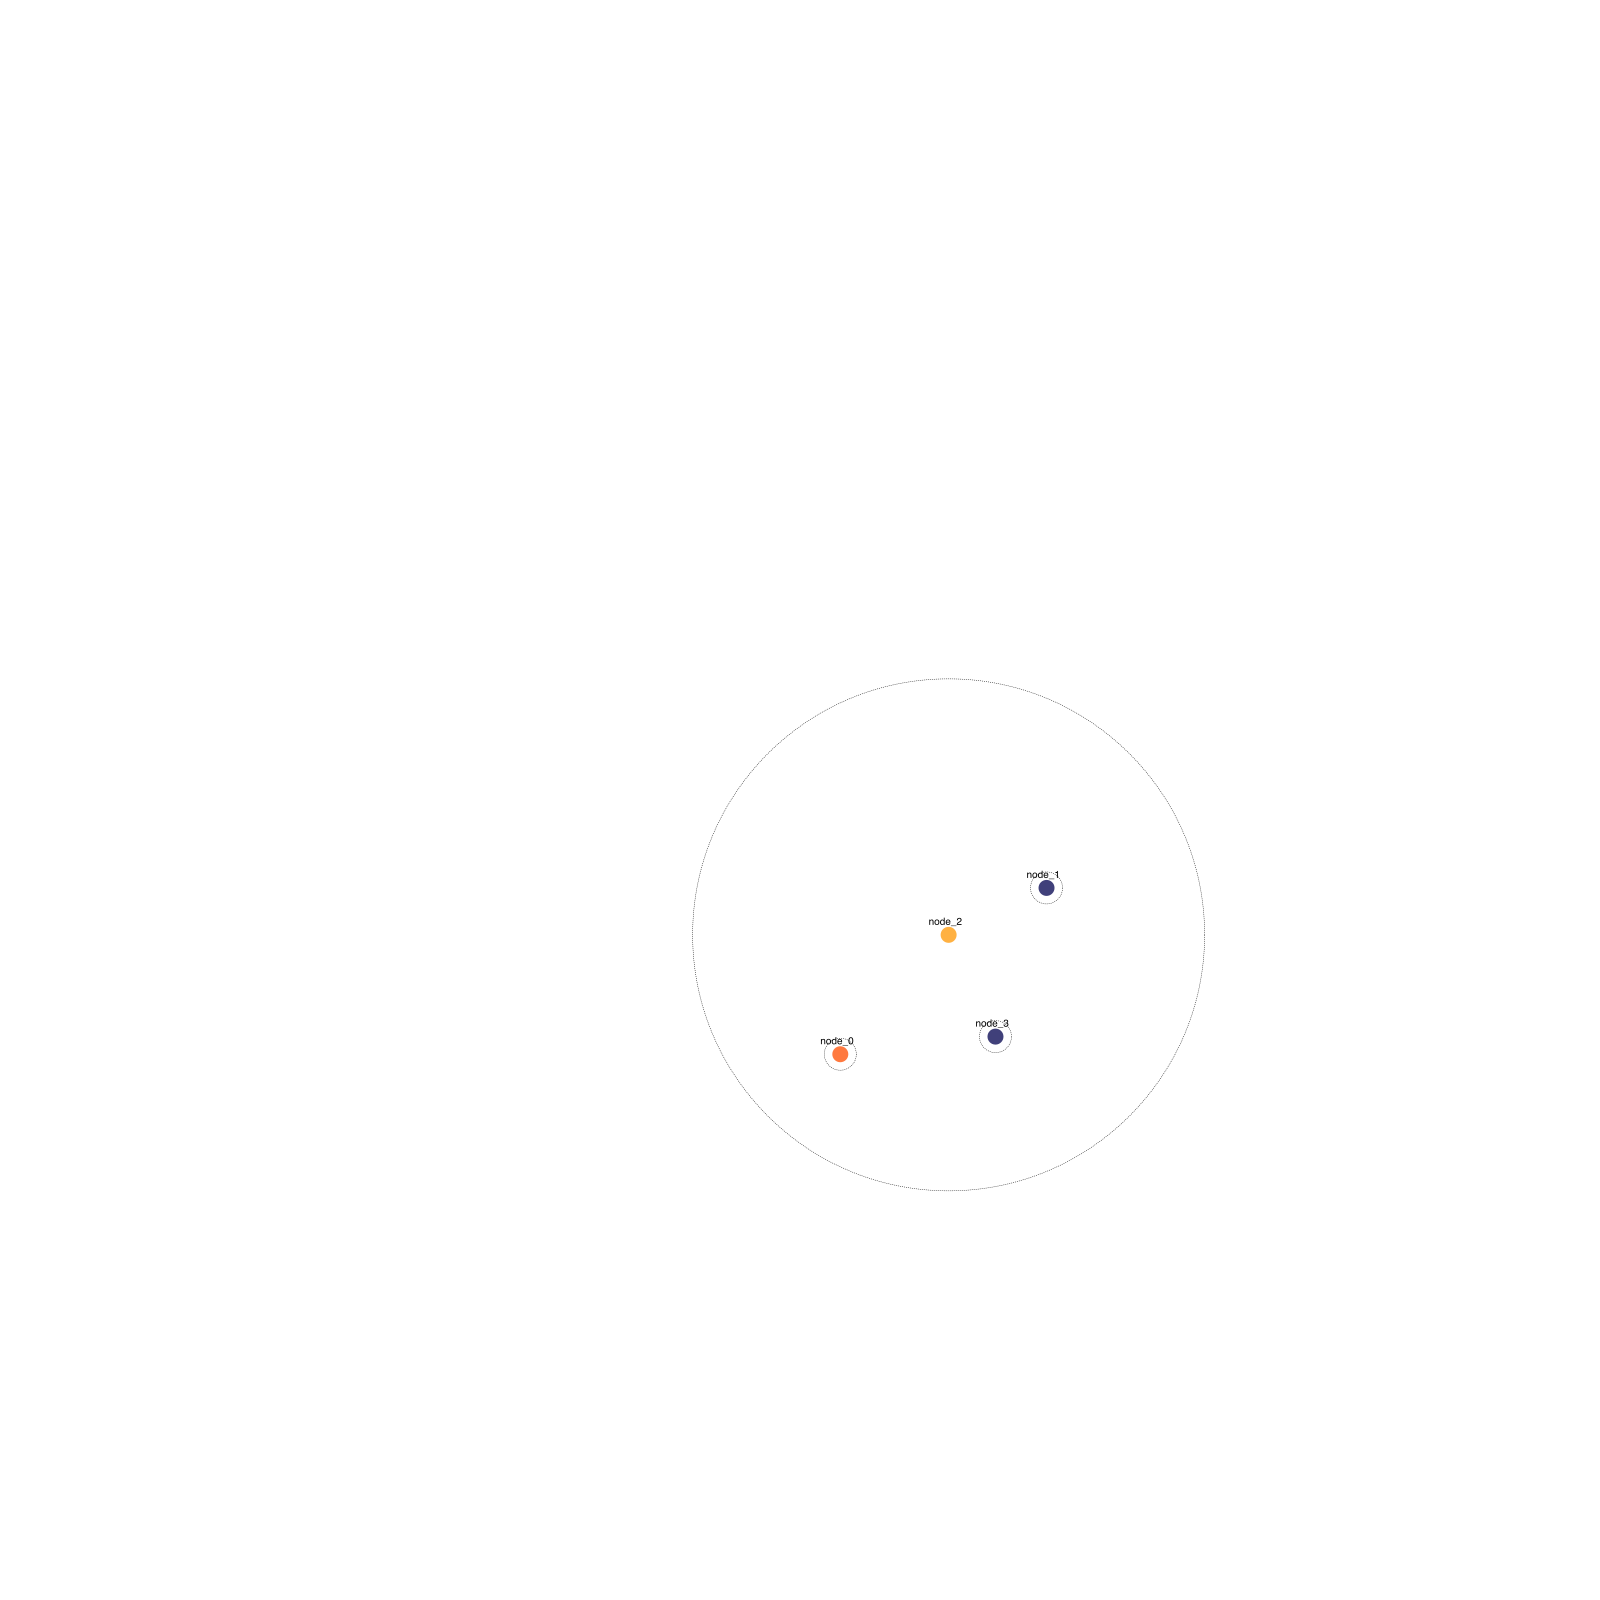

In [174]:
svgio = BytesIO()
side = 1600

def draw_df_on(Df,svgio):
    with cairo.SVGSurface(svgio, side, side) as surface:
        context = cairo.Context(surface)
        #context.scale(0.3,0.3)
        context.translate(side/2, side/2)

        context.set_source_rgba(0,0,0,1)
        context.set_dash([1.0])
        context.set_line_width(0.5)
        for row in Df.iterrows():
            Name, Level, X, Y, cluster, bunch, cluster_list, bunch_list = row[1]
            context.arc(X, Y, compute_radius(Name, Df, 16), 0, 2*np.pi)
            context.stroke()

        for row in Df.iterrows():
            Name, Level, X, Y, cluster, bunch, cluster_list, bunch_list = row[1]
            context.set_source_rgba(*palette[Level])
            context.arc(X, Y, 8, 0, 2*np.pi)
            context.fill()

        context.set_source_rgba(0,0,0,1)
        for row in Df.iterrows():
            Name, Level, X, Y, cluster, bunch, cluster_list, bunch_list = row[1]
            context.move_to(X-20,Y-10)
            context.show_text(Name)
            context.stroke()



draw_df_on(Df,svgio)
IPython.display.SVG(data=svgio.getvalue())
#svgio.close()

In [177]:
def compute_difference(old_Df, Df): 
    difference = 0    
    for row in Df.iterrows():
        Name, Level, X, Y, cluster, bunch, cluster_list, bunch_list = row[1]
        if len(old_Df) != 0 and len(old_Df[old_Df["Name"]==Name]) != 0:
            old_cluster_list = list(old_Df[old_Df["Name"]==Name].cluster_list)[0]
            old_bunch_list = list(old_Df[old_Df["Name"]==Name].bunch_list)[0]
            difference += len(cluster_list) - len(set(cluster_list) & set(old_cluster_list))
            difference += len(bunch_list) - len(set(bunch_list) & set(old_bunch_list))
            #print(old_cluster_list,cluster_list,set(cluster_list) & set(old_cluster_list))
        else:
            difference += len(cluster_list) + len(bunch_list)        
    return difference

52
16
16
26
52
36
70
70
58


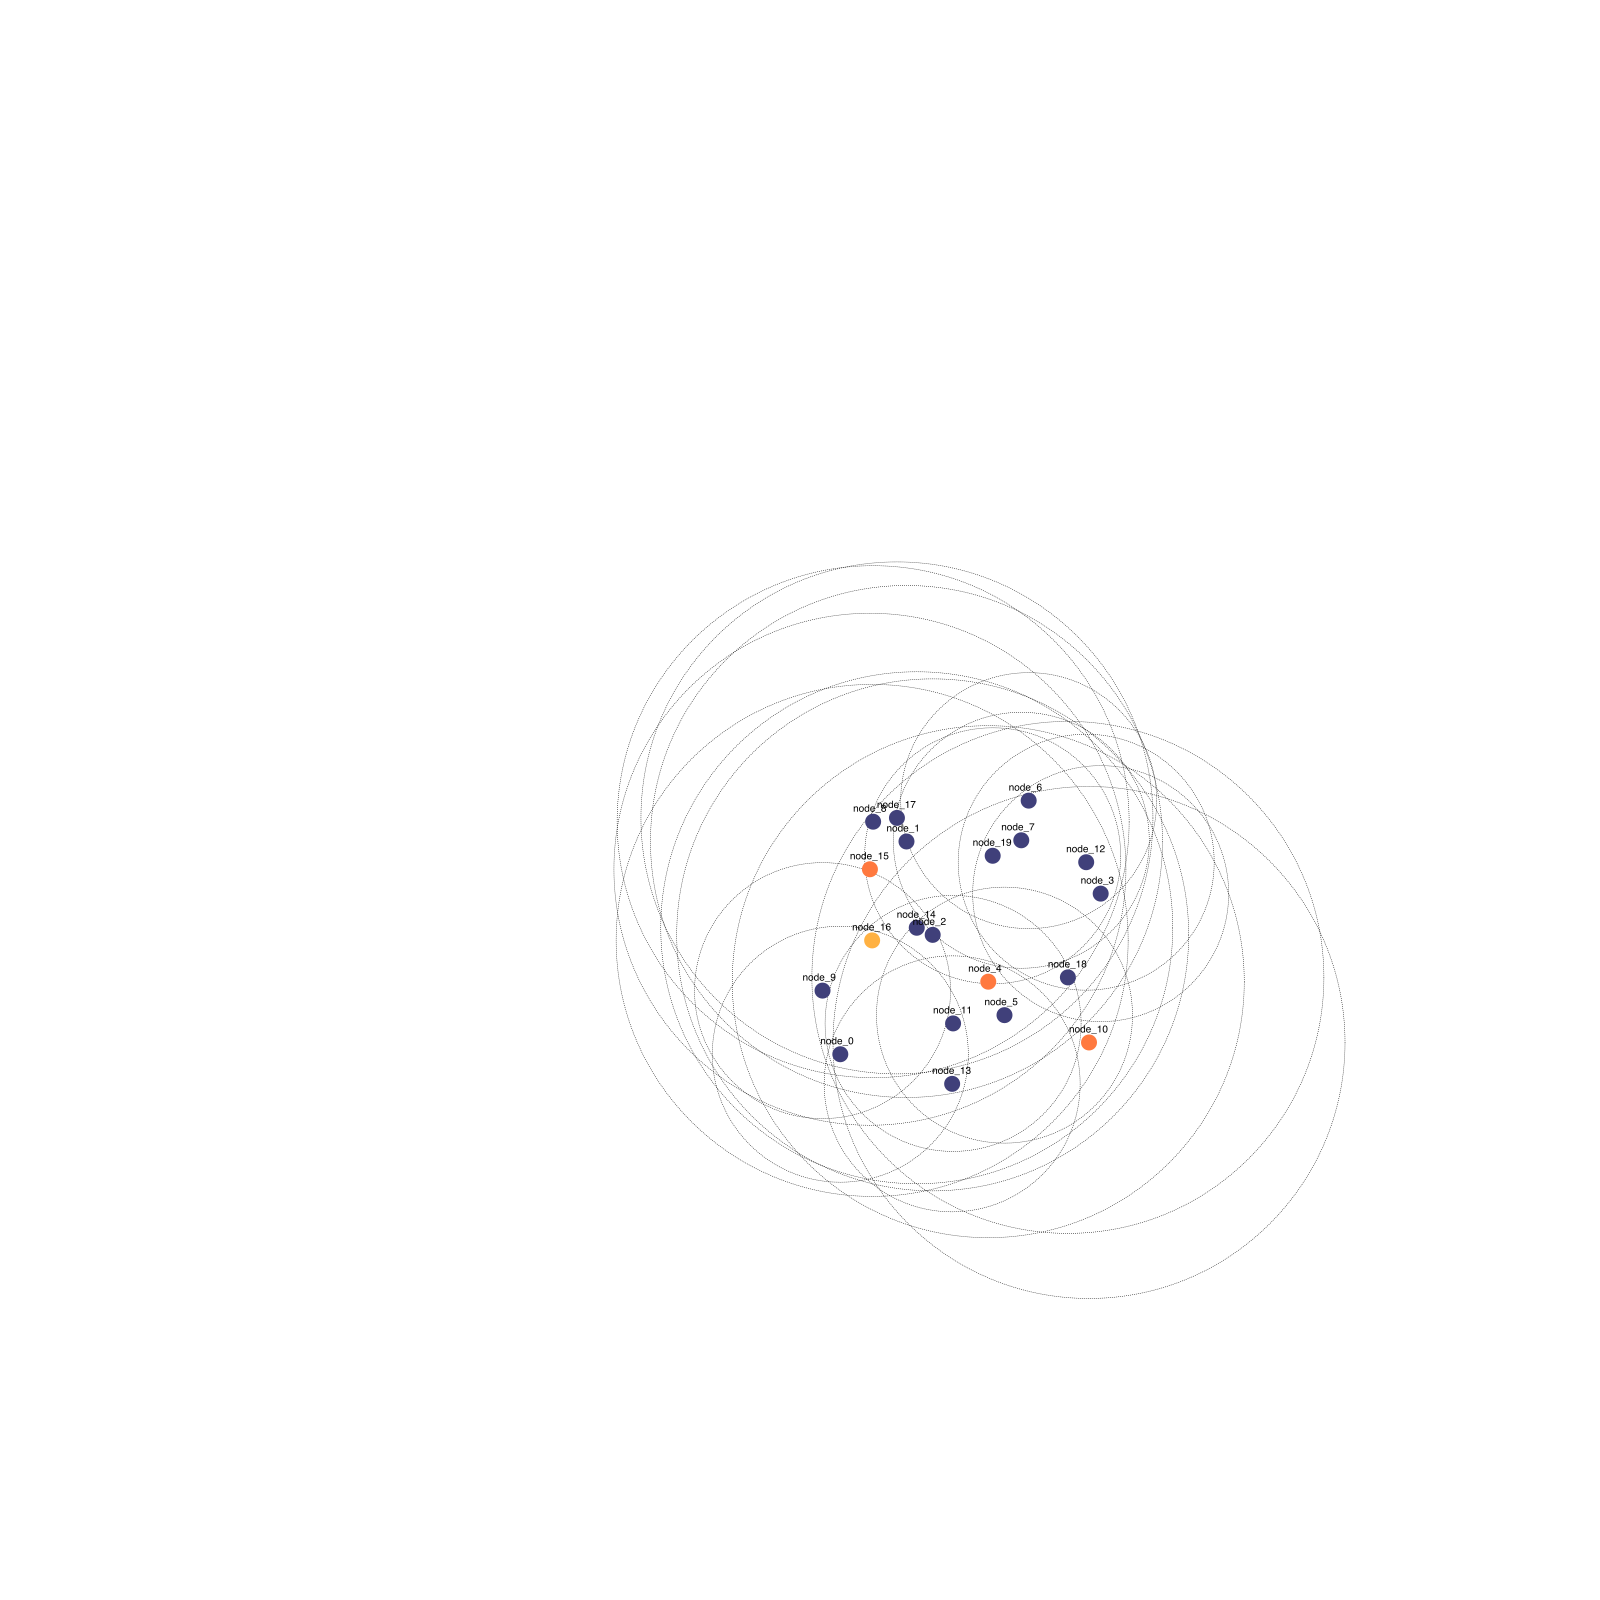

In [194]:
SVGs = []
Df = []
old_Df = []
differences = []
for epoch in range(1,10):  
    old_Df = Df
    Df = pd.read_csv("../../membershipchainservice/Data/gentree-node_0-epoch"+str(epoch))
    transform_Df(Df)
    svgio = BytesIO()
    SVGs.append(svgio)
    draw_df_on(Df, svgio)
    diff = compute_difference(old_Df, Df)
    differences.append(diff)
    print(diff)
    
IPython.display.SVG(data=svgio.getvalue())    

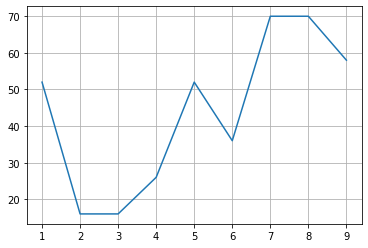

In [196]:
import matplotlib.pyplot as plt

epochs = [i for i in range(1,10)]

plt.plot(epochs, differences)
plt.grid(True)
plt.show()